In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [52]:
runoff = pd.read_csv('fish_river_flow.txt', sep='\t',skiprows=31, header=0)

In [53]:
runoff = runoff.set_index(['20d'])

In [54]:
runoff.index = pd.to_datetime(runoff.index)

In [55]:
runoff.head()

,5s,15s,6s,14n,10s
20d,,,,,
2000-01-01 00:00:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 00:30:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 01:00:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 01:30:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 02:00:00,USGS,2378500,CST,66.0,A:[91]


In [56]:
#drop unusable columns
cols = [0,1,2,4]
runoff.drop(runoff.columns[cols],axis=1,inplace=True)

In [57]:
#rename the runoff column
runoff.rename(columns={'14n': 'Runoff'}).head()

,Runoff
20d,
2000-01-01 00:00:00,66.0
2000-01-01 00:30:00,66.0
2000-01-01 01:00:00,66.0
2000-01-01 01:30:00,66.0
2000-01-01 02:00:00,66.0


In [58]:
runoff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311656 entries, 2000-01-01 00:00:00 to 2017-12-31 23:30:00
Data columns (total 1 columns):
14n    311656 non-null float64
dtypes: float64(1)
memory usage: 4.8 MB


In [59]:
#resample the data to daily
runoff_new = runoff.resample('D').mean()

In [60]:
runoff_new.tail()

,14n
20d,
2017-12-27,102.314583
2017-12-28,114.229167
2017-12-29,115.229167
2017-12-30,102.862500
2017-12-31,103.697917


In [61]:
runoff.describe()

,14n
count,311656.000000
mean,102.095316
std,239.183210
min,31.000000
25%,56.600000
50%,70.800000
75%,94.000000
max,18700.000000


In [62]:
runoff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311656 entries, 2000-01-01 00:00:00 to 2017-12-31 23:30:00
Data columns (total 1 columns):
14n    311656 non-null float64
dtypes: float64(1)
memory usage: 14.8 MB


In [63]:
weather = pd.read_csv('robertsdale_weather.csv')

In [64]:
weather.head()

,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
0,USC00016988,"ROBERTSDALE, AL US",2000-01-01,NaN,NaN,0.0,0.0,0.0,24.4,9.4,13.3
1,USC00016988,"ROBERTSDALE, AL US",2000-01-02,NaN,NaN,0.0,0.0,0.0,25.0,13.3,19.4
2,USC00016988,"ROBERTSDALE, AL US",2000-01-03,NaN,NaN,0.0,0.0,0.0,25.6,19.4,20.0
3,USC00016988,"ROBERTSDALE, AL US",2000-01-04,NaN,NaN,4.1,0.0,0.0,25.0,13.3,13.9
4,USC00016988,"ROBERTSDALE, AL US",2000-01-05,NaN,NaN,0.0,0.0,0.0,17.8,-1.1,1.1


In [65]:
weather = weather.set_index(['DATE'])

In [66]:
weather.index = pd.to_datetime(weather.index)

In [67]:
weather = weather[['PRCP','TMAX','TMIN']]

In [68]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6489 entries, 2000-01-01 to 2017-12-31
Data columns (total 3 columns):
PRCP    6341 non-null float64
TMAX    6275 non-null float64
TMIN    6278 non-null float64
dtypes: float64(3)
memory usage: 202.8 KB


In [69]:
weather.isnull().sum()

PRCP    148
TMAX    214
TMIN    211
dtype: int64

In [70]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6489 entries, 2000-01-01 to 2017-12-31
Data columns (total 3 columns):
PRCP    6341 non-null float64
TMAX    6275 non-null float64
TMIN    6278 non-null float64
dtypes: float64(3)
memory usage: 202.8 KB


In [71]:
weather.PRCP.max()

365.5

In [72]:
combined = pd.merge(runoff_new,weather,how="outer",left_index=True, right_index=True)

In [73]:
combined.head()

,14n,PRCP,TMAX,TMIN
2000-01-01,65.458333,0.0,24.4,9.4
2000-01-02,65.145833,0.0,25.0,13.3
2000-01-03,64.583333,0.0,25.6,19.4
2000-01-04,65.208333,4.1,25.0,13.3
2000-01-05,64.291667,0.0,17.8,-1.1


In [74]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6575 entries, 2000-01-01 to 2017-12-31
Data columns (total 4 columns):
14n     6495 non-null float64
PRCP    6341 non-null float64
TMAX    6275 non-null float64
TMIN    6278 non-null float64
dtypes: float64(4)
memory usage: 256.8 KB


In [75]:
combined.PRCP.fillna(0,inplace=True)

In [76]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6575 entries, 2000-01-01 to 2017-12-31
Data columns (total 4 columns):
14n     6495 non-null float64
PRCP    6575 non-null float64
TMAX    6275 non-null float64
TMIN    6278 non-null float64
dtypes: float64(4)
memory usage: 256.8 KB


In [77]:
combined.fillna(method='ffill',inplace=True)

In [78]:
combined.describe()

,14n,PRCP,TMAX,TMIN
count,6575.000000,6575.000000,6575.000000,6575.000000
mean,101.847366,4.545414,25.574768,13.755148
std,208.547926,15.278772,6.864929,8.224098
min,34.810638,0.000000,0.000000,-9.400000
25%,56.739583,0.000000,21.700000,7.200000
50%,71.091667,0.000000,26.700000,15.600000
75%,95.263542,0.300000,31.100000,21.100000
max,10081.666667,365.500000,39.400000,28.300000


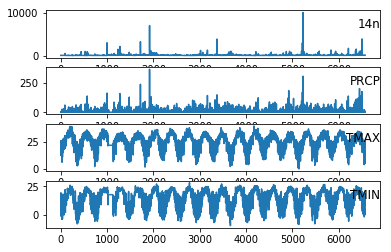

In [79]:
#plot all the time series variables
values = combined.values
i = 1
plt.figure()
groups = list(range(0,4))
for n in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:,n])
    plt.title(combined.columns[n], y=0.5, loc='right')
    i += 1
plt.show()

In [80]:
list(range(1,5))

[1, 2, 3, 4]

In [81]:
#converting values of features into array
array_values = combined.values

In [82]:
array_values

array([[ 65.45833333,   0.        ,  24.4       ,   9.4       ],
       [ 65.14583333,   0.        ,  25.        ,  13.3       ],
       [ 64.58333333,   0.        ,  25.6       ,  19.4       ],
       ...,
       [115.22916667,   0.        ,   5.        ,   1.1       ],
       [102.8625    ,   0.        ,  13.3       ,   1.1       ],
       [103.69791667,   7.1       ,  15.        ,   5.        ]])

In [83]:
#scale all the features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(array_values)

In [84]:
df = pd.DataFrame(scaled)

In [85]:
df.head()

,0,1,2,3
0,0.003050,0.000000,0.619289,0.498674
1,0.003019,0.000000,0.634518,0.602122
2,0.002963,0.000000,0.649746,0.763926
3,0.003026,0.011218,0.634518,0.602122
4,0.002934,0.000000,0.451777,0.220159


In [86]:
type(scaled)

numpy.ndarray

In [87]:
cols = list()

In [88]:
cols = df.shift(0)

In [89]:

def transform(data, vars_in=1, vars_out=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    cols = list()
    names = list()
    for i in range(vars_in, 0, -1):
        cols.append(data.shift(i))
        names += ['var%d(t-%d)' %(j+1, i) for j in range(n_vars)]
    for i in range (0, vars_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('var%d(t)' %(j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' %(j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


In [90]:
new_df = transform(df,1, 1)

In [91]:
new_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
0,NaN,NaN,NaN,NaN,0.003050,0.000000,0.619289,0.498674
1,0.003050,0.000000,0.619289,0.498674,0.003019,0.000000,0.634518,0.602122
2,0.003019,0.000000,0.634518,0.602122,0.002963,0.000000,0.649746,0.763926
3,0.002963,0.000000,0.649746,0.763926,0.003026,0.011218,0.634518,0.602122
4,0.003026,0.011218,0.634518,0.602122,0.002934,0.000000,0.451777,0.220159


In [92]:
new_df.drop(new_df.columns[[5,6,7]], axis=1, inplace=True)

In [93]:
new_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
0,NaN,NaN,NaN,NaN,0.003050
1,0.003050,0.000000,0.619289,0.498674,0.003019
2,0.003019,0.000000,0.634518,0.602122,0.002963
3,0.002963,0.000000,0.649746,0.763926,0.003026
4,0.003026,0.011218,0.634518,0.602122,0.002934


In [94]:
values = new_df.values
n_train_days = 365*10
train = values[:n_train_days, :]
test = values[n_train_days:, :]

#specify input and output values
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]

train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3650, 1, 4) (3650,) (2925, 1, 4) (2925,)


In [95]:
train_X

array([[[       nan,        nan,        nan,        nan]],

       [[0.00305048, 0.        , 0.61928934, 0.49867374]],

       [[0.00301937, 0.        , 0.63451777, 0.60212202]],

       ...,

       [[0.02931699, 0.08071135, 0.53553299, 0.4270557 ]],

       [[0.01378974, 0.        , 0.25380711, 0.24933687]],

       [[0.00923608, 0.        , 0.29695431, 0.27851459]]])

In [ ]:
#specify the network with 30 hidden neurons in the first hidden layer

ann = Sequential()
ann.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
ann.add(Dense(1))
ann.compile(loss='mae', optimizer='adam')


#fit the model
model_run = ann.fit(train_X, train_y, epochs=60, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#plot model optimization
pyplot.plot(model_run.history['loss'], label='training phase')
pyplot.plot(model_run.history['val_loss'], label='testing phase')
pyplot.legend()
pyplot.show()

Train on 3650 samples, validate on 2925 samples
Epoch 1/60
